In [1]:
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models
from collections import OrderedDict

import utils
import matplotlib.pyplot as plt

import os
import random as rn
import numpy as np
from tqdm import tqdm

SEED = 7
os.environ["PYTHONHASHSEED"] = str(SEED)
rn.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

In [2]:
data_dir = 'data/'

In [3]:
train_transforms = transforms.Compose([transforms.RandomRotation(5),
                                       transforms.Resize((224,224)),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])
                                      ])

valid_transforms = transforms.Compose([transforms.Resize((224,224)),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])
                                      ])

In [4]:
# Pass transforms in here, then run the next cell to see how the transforms look
train_data = datasets.ImageFolder(data_dir + '/train', transform=train_transforms)
valid_data = datasets.ImageFolder(data_dir + '/val', transform=valid_transforms)

trainloader = torch.utils.data.DataLoader(train_data, batch_size=16, shuffle=True)
validloader = torch.utils.data.DataLoader(valid_data, batch_size=16)

print('Train set: ', len(trainloader.dataset))
print('Valid set: ', len(validloader.dataset))

Train set:  106
Valid set:  30


Training images


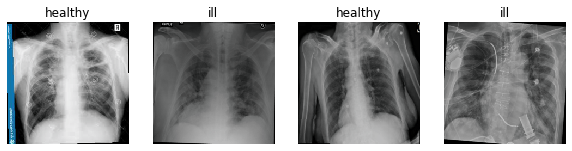

In [5]:
print('Training images')
images, labels = next(iter(trainloader))

fig, axes = plt.subplots(figsize=(10,4), ncols=4)
for ii in range(4):
    ax = axes[ii]
    utils.imshow(images[ii], ax=ax, normalize=True, title=train_data.classes[labels[ii]])

Validation images


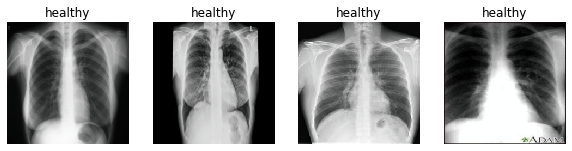

In [6]:
print('Validation images')
images, labels = next(iter(validloader))

fig, axes = plt.subplots(figsize=(10,4), ncols=4)
for ii in range(4):
    ax = axes[ii]
    utils.imshow(images[ii], ax=ax, normalize=True, title=valid_data.classes[labels[ii]])

# TRAINING MODEL

In [7]:
### Load model (pretained on imagenet)
model = utils.ResNet18(imagenet_weights=False)

In [8]:
# Use device available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('Training using {}'.format(device))

Training using cuda:0


In [9]:
epochs = 35
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(),lr=0.00001) # 0.00001

train_losses, valid_losses = [], []
train_accuracies, valid_accuracies = [], []
valid_loss_min = np.Inf

model.to(device)

for e in range(epochs):
    print('------------------------ EPOCH {} ------------------------'.format(e))
    # monitor loss
    train_loss = 0.0
    valid_loss = 0.0
    
    # monitor accuracy
    train_accuracy = 0
    valid_accuracy = 0
    
    ###################
    # train the model #
    ###################
    print('Training')
    model.train() #train_mode
    for data, target in tqdm(trainloader):
        data, target = data.to(device), target.to(device)
        
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output,target)
        
        loss.backward()
        optimizer.step()
        
        _, predicted = torch.max(output.data, 1)
        equals = predicted == target
        
        train_accuracy += 100 * torch.mean(equals.type(torch.FloatTensor)).item()
        train_loss += loss.item()         
    
    ######################
    # validate the model #
    ######################
    print('Testing')
    with torch.no_grad():
        model.eval() #test_model        
        for data, target in validloader:
            data, target = data.to(device), target.to(device)
            
            output = model(data)
            _, predicted = torch.max(output.data, 1)
            equals = predicted == target

            valid_accuracy += 100 * torch.mean(equals.type(torch.FloatTensor)).item()
            valid_loss += criterion(output,target).item()

    train_losses.append(train_loss/len(trainloader))
    valid_losses.append(valid_loss/len(validloader))
    
    train_accuracies.append(train_accuracy/len(trainloader))
    valid_accuracies.append(valid_accuracy/len(validloader))

    print('Train loss {:.3f}'.format(train_loss/len(trainloader)), "\t", 'Train accuracy {:.3f}'.format(train_accuracy/len(trainloader)))
    print('Valid loss {:.3f}'.format(valid_loss/len(validloader)), "\t", 'Valid accuracy {:.3f}'.format(valid_accuracy/len(validloader)))
    
    ###################
    # Save best model #
    ###################
    epoch_valid_loss = valid_loss/len(validloader)
    if epoch_valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:6f} --> {:6f}). Saving model ...'.format(
        valid_loss_min,
        epoch_valid_loss))
        torch.save(model.state_dict(), 'models/ResNet18.pth')
        valid_loss_min = epoch_valid_loss

------------------------ EPOCH 0 ------------------------
Training


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:07<00:00,  1.03s/it]


Testing
Train loss 0.605 	 Train accuracy 68.750
Valid loss 0.636 	 Valid accuracy 71.875
Validation loss decreased (   inf --> 0.635708). Saving model ...
------------------------ EPOCH 1 ------------------------
Training


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:05<00:00,  1.28it/s]


Testing
Train loss 0.680 	 Train accuracy 60.893
Valid loss 0.567 	 Valid accuracy 68.750
Validation loss decreased (0.635708 --> 0.567183). Saving model ...
------------------------ EPOCH 2 ------------------------
Training


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:05<00:00,  1.28it/s]


Testing
Train loss 0.594 	 Train accuracy 67.679
Valid loss 0.520 	 Valid accuracy 71.875
Validation loss decreased (0.567183 --> 0.519513). Saving model ...
------------------------ EPOCH 3 ------------------------
Training


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:05<00:00,  1.27it/s]


Testing
Train loss 0.542 	 Train accuracy 71.964
Valid loss 0.477 	 Valid accuracy 81.250
Validation loss decreased (0.519513 --> 0.476696). Saving model ...
------------------------ EPOCH 4 ------------------------
Training


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:05<00:00,  1.27it/s]


Testing
Train loss 0.554 	 Train accuracy 72.500
Valid loss 0.442 	 Valid accuracy 84.375
Validation loss decreased (0.476696 --> 0.441761). Saving model ...
------------------------ EPOCH 5 ------------------------
Training


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:05<00:00,  1.28it/s]


Testing
Train loss 0.473 	 Train accuracy 76.250
Valid loss 0.413 	 Valid accuracy 87.500
Validation loss decreased (0.441761 --> 0.413237). Saving model ...
------------------------ EPOCH 6 ------------------------
Training


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:05<00:00,  1.27it/s]


Testing
Train loss 0.448 	 Train accuracy 78.750
Valid loss 0.385 	 Valid accuracy 90.625
Validation loss decreased (0.413237 --> 0.384666). Saving model ...
------------------------ EPOCH 7 ------------------------
Training


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:05<00:00,  1.28it/s]


Testing
Train loss 0.444 	 Train accuracy 80.357
Valid loss 0.369 	 Valid accuracy 90.625
Validation loss decreased (0.384666 --> 0.368784). Saving model ...
------------------------ EPOCH 8 ------------------------
Training


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:05<00:00,  1.24it/s]


Testing
Train loss 0.480 	 Train accuracy 76.964
Valid loss 0.349 	 Valid accuracy 90.625
Validation loss decreased (0.368784 --> 0.349098). Saving model ...
------------------------ EPOCH 9 ------------------------
Training


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:05<00:00,  1.26it/s]


Testing
Train loss 0.400 	 Train accuracy 81.964
Valid loss 0.339 	 Valid accuracy 90.625
Validation loss decreased (0.349098 --> 0.339219). Saving model ...
------------------------ EPOCH 10 ------------------------
Training


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:05<00:00,  1.27it/s]


Testing
Train loss 0.419 	 Train accuracy 79.821
Valid loss 0.328 	 Valid accuracy 93.304
Validation loss decreased (0.339219 --> 0.327946). Saving model ...
------------------------ EPOCH 11 ------------------------
Training


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:05<00:00,  1.30it/s]


Testing
Train loss 0.447 	 Train accuracy 81.250
Valid loss 0.317 	 Valid accuracy 93.304
Validation loss decreased (0.327946 --> 0.317450). Saving model ...
------------------------ EPOCH 12 ------------------------
Training


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:05<00:00,  1.25it/s]


Testing
Train loss 0.377 	 Train accuracy 86.429
Valid loss 0.307 	 Valid accuracy 96.875
Validation loss decreased (0.317450 --> 0.307292). Saving model ...
------------------------ EPOCH 13 ------------------------
Training


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:05<00:00,  1.28it/s]


Testing
Train loss 0.351 	 Train accuracy 86.071
Valid loss 0.304 	 Valid accuracy 96.875
Validation loss decreased (0.307292 --> 0.303740). Saving model ...
------------------------ EPOCH 14 ------------------------
Training


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:05<00:00,  1.22it/s]


Testing
Train loss 0.360 	 Train accuracy 84.821
Valid loss 0.292 	 Valid accuracy 96.875
Validation loss decreased (0.303740 --> 0.291908). Saving model ...
------------------------ EPOCH 15 ------------------------
Training


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:05<00:00,  1.26it/s]


Testing
Train loss 0.293 	 Train accuracy 87.500
Valid loss 0.284 	 Valid accuracy 96.875
Validation loss decreased (0.291908 --> 0.284241). Saving model ...
------------------------ EPOCH 16 ------------------------
Training


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:05<00:00,  1.26it/s]


Testing
Train loss 0.307 	 Train accuracy 89.286
Valid loss 0.284 	 Valid accuracy 93.750
Validation loss decreased (0.284241 --> 0.283553). Saving model ...
------------------------ EPOCH 17 ------------------------
Training


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:05<00:00,  1.26it/s]


Testing
Train loss 0.340 	 Train accuracy 85.000
Valid loss 0.284 	 Valid accuracy 93.750
------------------------ EPOCH 18 ------------------------
Training


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:05<00:00,  1.26it/s]


Testing
Train loss 0.328 	 Train accuracy 85.536
Valid loss 0.288 	 Valid accuracy 93.750
------------------------ EPOCH 19 ------------------------
Training


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:05<00:00,  1.25it/s]


Testing
Train loss 0.358 	 Train accuracy 85.000
Valid loss 0.267 	 Valid accuracy 93.750
Validation loss decreased (0.283553 --> 0.267043). Saving model ...
------------------------ EPOCH 20 ------------------------
Training


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:05<00:00,  1.27it/s]


Testing
Train loss 0.294 	 Train accuracy 88.750
Valid loss 0.244 	 Valid accuracy 96.875
Validation loss decreased (0.267043 --> 0.244462). Saving model ...
------------------------ EPOCH 21 ------------------------
Training


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:05<00:00,  1.27it/s]


Testing
Train loss 0.288 	 Train accuracy 91.429
Valid loss 0.233 	 Valid accuracy 96.875
Validation loss decreased (0.244462 --> 0.232760). Saving model ...
------------------------ EPOCH 22 ------------------------
Training


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:05<00:00,  1.28it/s]


Testing
Train loss 0.290 	 Train accuracy 87.857
Valid loss 0.227 	 Valid accuracy 96.875
Validation loss decreased (0.232760 --> 0.227460). Saving model ...
------------------------ EPOCH 23 ------------------------
Training


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:05<00:00,  1.26it/s]


Testing
Train loss 0.262 	 Train accuracy 91.786
Valid loss 0.230 	 Valid accuracy 93.750
------------------------ EPOCH 24 ------------------------
Training


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:05<00:00,  1.28it/s]


Testing
Train loss 0.316 	 Train accuracy 89.286
Valid loss 0.280 	 Valid accuracy 90.625
------------------------ EPOCH 25 ------------------------
Training


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:05<00:00,  1.27it/s]


Testing
Train loss 0.319 	 Train accuracy 85.000
Valid loss 0.278 	 Valid accuracy 90.625
------------------------ EPOCH 26 ------------------------
Training


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:05<00:00,  1.29it/s]


Testing
Train loss 0.273 	 Train accuracy 87.857
Valid loss 0.229 	 Valid accuracy 93.750
------------------------ EPOCH 27 ------------------------
Training


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:05<00:00,  1.26it/s]


Testing
Train loss 0.242 	 Train accuracy 89.286
Valid loss 0.215 	 Valid accuracy 93.750
Validation loss decreased (0.227460 --> 0.215209). Saving model ...
------------------------ EPOCH 28 ------------------------
Training


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:05<00:00,  1.25it/s]


Testing
Train loss 0.193 	 Train accuracy 94.643
Valid loss 0.217 	 Valid accuracy 93.750
------------------------ EPOCH 29 ------------------------
Training


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:05<00:00,  1.27it/s]


Testing
Train loss 0.204 	 Train accuracy 91.071
Valid loss 0.221 	 Valid accuracy 93.750
------------------------ EPOCH 30 ------------------------
Training


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:05<00:00,  1.27it/s]


Testing
Train loss 0.232 	 Train accuracy 88.750
Valid loss 0.196 	 Valid accuracy 93.750
Validation loss decreased (0.215209 --> 0.196265). Saving model ...
------------------------ EPOCH 31 ------------------------
Training


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:05<00:00,  1.27it/s]


Testing
Train loss 0.241 	 Train accuracy 90.536
Valid loss 0.216 	 Valid accuracy 93.750
------------------------ EPOCH 32 ------------------------
Training


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:05<00:00,  1.25it/s]


Testing
Train loss 0.179 	 Train accuracy 93.750
Valid loss 0.208 	 Valid accuracy 93.750
------------------------ EPOCH 33 ------------------------
Training


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:05<00:00,  1.26it/s]


Testing
Train loss 0.315 	 Train accuracy 90.357
Valid loss 0.202 	 Valid accuracy 93.750
------------------------ EPOCH 34 ------------------------
Training


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:05<00:00,  1.24it/s]


Testing
Train loss 0.174 	 Train accuracy 94.643
Valid loss 0.178 	 Valid accuracy 93.750
Validation loss decreased (0.196265 --> 0.178418). Saving model ...


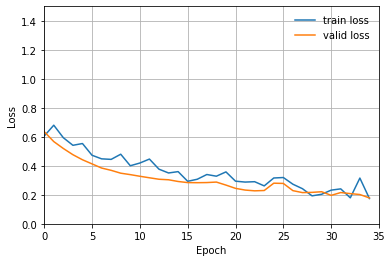

In [10]:
plt.plot(train_losses,label='train loss')
plt.plot(valid_losses, label='valid loss')
plt.legend(frameon=False)
plt.xlim([0,epochs])
plt.ylim([0,1.5])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid()
plt.savefig('models/train_val_loss.jpg')
np.save('models/train_val_loss.npy',{'train_loss': train_losses, 'val_loss': valid_losses})

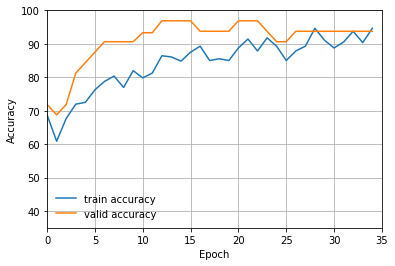

In [11]:
plt.plot(train_accuracies,label='train accuracy')
plt.plot(valid_accuracies, label='valid accuracy')
plt.legend(frameon=False)
plt.xlim([0,epochs])
plt.ylim([35,100])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid()
plt.savefig('models/train_val_acc.jpg')
np.save('models/train_val_acc.npy',{'train_acc': train_accuracies, 'val_acc': valid_accuracies})

In [12]:
torch.cuda.empty_cache()

# TESTING MODEL

In [13]:
def testing_model(data_dir, model_to_test):
    
    # Loading data and tranformations
    test_transform = transforms.Compose([transforms.Resize((224,224)),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])
                                      ])
    test_data = datasets.ImageFolder(data_dir, transform=test_transform)
    loader = torch.utils.data.DataLoader(test_data, batch_size=64)
    print('Test set: ', len(loader.dataset))

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model_to_test.to(device)
    
    pred=[]
    groundtruth=[]
    
    test_loss = 0.0
    test_accuracy = 0

    list_clases = loader.dataset.classes
    criterion = nn.NLLLoss()

    with torch.no_grad():
        model_to_test.eval() #test_model        
        for data, target in tqdm(loader):

            data, target = data.to(device), target.to(device)

            output = model_to_test(data)
            _, predicted = torch.max(output.data, 1)

            pred.extend(predicted.cpu().numpy())
            groundtruth.extend(target.cpu().numpy())

            equals = predicted == target

            test_accuracy += 100 * torch.mean(equals.type(torch.FloatTensor)).item()
            test_loss += criterion(output,target).item()

    print('loss {:.3f}'.format(test_loss/len(loader)), "\t", 'accuracy {:.3f}'.format(test_accuracy/len(loader)))
    
    groundtruth = [test_data.classes[k] for k in groundtruth]
    pred = [test_data.classes[k] for k in pred]
    
    from sklearn import metrics
    import seaborn as sns 
    
    print(metrics.classification_report(groundtruth, pred))
    
    print('Test Confusion Matrix')
    cm = metrics.confusion_matrix(groundtruth,pred,list(test_data.classes))
    
    #plt.figure(figsize=(18,10))
    sns.heatmap(cm, annot=True, annot_kws={"size": 20}, 
                fmt='g', cmap='Blues', xticklabels=list_clases, yticklabels=list_clases)
    plt.savefig('models/cm.jpg')
    plt.show()
    
    print('Test Normalized Confusion Matrix ')
    #plt.figure(figsize=(18,10))
    cm = np.round(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis],2) # normalized
    sns.heatmap(cm, annot=True, annot_kws={"size": 20}, 
                fmt='g', cmap='Blues', xticklabels=list_clases, yticklabels=list_clases)
    plt.savefig('models/cm_normalized.jpg')
    plt.show()
    return None
    

In [14]:
### Loading best model
best_model = utils.ResNet18(imagenet_weights=False)
best_model.load_state_dict(torch.load('models/ResNet18.pth'))

<All keys matched successfully>

Test set:  16


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.19it/s]


loss 0.112 	 accuracy 100.000
              precision    recall  f1-score   support

     healthy       1.00      1.00      1.00         5
         ill       1.00      1.00      1.00        11

    accuracy                           1.00        16
   macro avg       1.00      1.00      1.00        16
weighted avg       1.00      1.00      1.00        16

Test Confusion Matrix


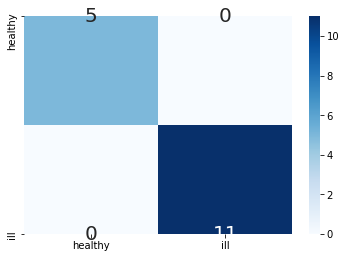

Test Normalized Confusion Matrix 


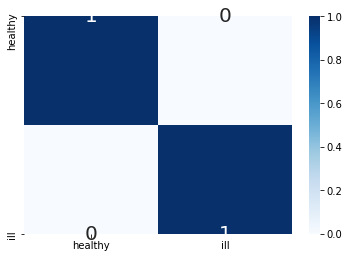

In [15]:
# Test model
test_dir = data_dir + '/test'
testing_model(test_dir, best_model)

In [16]:
torch.cuda.empty_cache()